## Downloading and extracting the Fashionpedia dataset

In [1]:
# This creates a git filter that strips the notebook output when committing
!git config filter.strip-notebook-output.clean 'jupyter nbconvert --ClearOutputPreprocessor.enabled=True --to=notebook --stdin --stdout --log-level=ERROR'

# Download dataset (4 GB)
!mkdir fashionpedia
!mkdir fashionpedia/img

!curl https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip -o fashionpedia/train.zip
!unzip fashionpedia/train.zip -d fashionpedia/img
!rm fashionpedia/train.zip

!curl https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json -o fashionpedia/attributes.json

## Preprocess data

In [66]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import lib.fashionpedia_type as fpt
from tqdm.autonotebook import tqdm
from PIL import Image, ImageDraw, ImageOps

# Dataset sampling conditions
SUPERCATEGORY = 'upperbody'
DATASET_SIZE = 100
MIN_GARMENT_AREA = 1

In [3]:
with open('fashionpedia/attributes.json') as item:
    att: fpt.FashionPedia = json.load(item)

In [67]:
selected_cat = [cat for cat in att['categories'] if cat['supercategory'] == SUPERCATEGORY]
selected_cat_ids = [cat['id'] for cat in selected_cat]

print("Selected categories:", [cat['name'] for cat in selected_cat])

Selected categories: ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest']


In [5]:
def get_by_id(group, id):
    for item in att[group]:
        if item['id'] == id:
            return item

73594


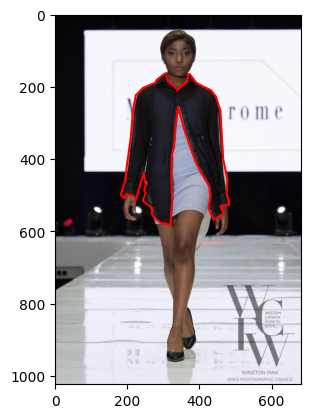

In [7]:
def show_segmentation(annotation: fpt.Annotation):
    file_name = get_by_id('images', annotation['image_id'])['file_name']
    img = mpimg.imread(f'fashionpedia/img/train/{file_name}') # Too much trouble to move all the images so let's work with two location :)
    # img = mpimg.imread(f'fashionpedia/img/{file_name}')
    plt.imshow(img)

    seg = annotation['segmentation'][0]
    xs = seg[::2]
    ys = seg[1::2]
    plt.plot(xs, ys, c='red')

    plt.show()

test = get_by_id('annotations', 11)
print(test['area'])
show_segmentation(test)
        

In [52]:
def get_dominant_colour(img):
	NUM_CLUSTERS = 5
	img = img.resize((150, 150)) # For speed

	ar = np.asarray(img)
	shape = ar.shape
	ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

	codes, _ = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
	vecs, _ = scipy.cluster.vq.vq(ar, codes)         # assign codes
	counts, _ = scipy.histogram(vecs, len(codes))    # count occurrences

	index_max = scipy.argmax(counts)                    # find most frequent
	peak = codes[index_max]
	colour = list(int(c) for c in peak)

	return colour



C:\Users\gijsa\AppData\Local\Temp\ipykernel_9424\264010643.py:7: DeprecationWarning: scipy.product is deprecated and will be removed in SciPy 2.0.0, use numpy.product instead
  ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
C:\Users\gijsa\AppData\Local\Temp\ipykernel_9424\264010643.py:11: DeprecationWarning: scipy.histogram is deprecated and will be removed in SciPy 2.0.0, use numpy.histogram instead
  counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
C:\Users\gijsa\AppData\Local\Temp\ipykernel_9424\264010643.py:13: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  index_max = scipy.argmax(counts)                    # find most frequent


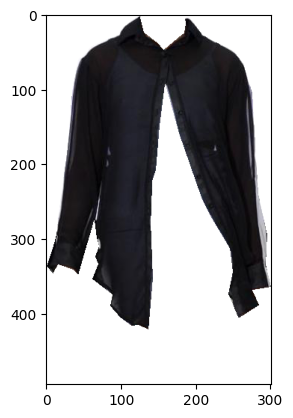

In [79]:
def crop_segmentation(annotation: fpt.Annotation):
    file_name = get_by_id('images', annotation['image_id'])['file_name']
    img = Image.open(f'fashionpedia/img/train/{file_name}') # Too much trouble to move all the images so let's work with two location :)
    # img = Image.open(f'fashionpedia/img/{file_name}')

    mask = Image.new('1', img.size, 0)
    inv_mask = Image.new('1', img.size, 1)

    # Mask
    seg = annotation['segmentation'][0]
    points = list(zip(*(iter(seg),) * 2))

    ImageDraw.Draw(mask).polygon(points, outline=1, fill=1)
    ImageDraw.Draw(inv_mask).polygon(points, outline=1, fill=0)

    # TODO: this makes all masked pixels transparent, but their color value is still the same, so the information is still there. We should make the masked pixels black or white first
    
    # crop to bounding box
    x, y, width, height = map(int, annotation['bbox'])
    cropped_image_dominant = img.crop((x, y, x + width, y + height))

    dominant_colour = get_dominant_colour(cropped_image_dominant)

    # If we have a high chroma image we set background colour black otherwise we set it to white
    if (dominant_colour[0] >= 175 and dominant_colour[1] >= 175 and dominant_colour[2] <= 75) or \
        (dominant_colour[0] <= 75 and dominant_colour[1] >= 175 and dominant_colour[2] <= 75) or \
        (dominant_colour[0] <= 75 and dominant_colour[1] >= 175 and dominant_colour[2] >= 175) or \
        (dominant_colour[0] >= 175 and dominant_colour[1] <= 75 and dominant_colour[2] >= 175) or \
        (dominant_colour[0] >= 175 and dominant_colour[1] >= 175 and dominant_colour[2] >= 175):
        # Set background black
        img.paste((0, 0, 0), inv_mask)
    else:
        # Set background white
        img.paste((256, 256, 256), inv_mask)

    # img.putalpha(mask)

    # crop to bounding box
    # x, y, width, height = map(int, annotation['bbox'])
    cropped_image = img.crop((x, y, x + width, y + height))

    return cropped_image

test = get_by_id('annotations', 11)
plt.imshow(crop_segmentation(test))
plt.show()

In [81]:
dataset = []
SELECTED_CATEGORIES = [6] # cat 6 is pants
SELECTED_ATTRIBUTES = np.arange(start=36, stop=50, step=1) # att 36 - 49 are pants attributes like: [jeans, cargo, sweat, camo, ...]


for ann in att['annotations']:
    # if not ann['category_id'] in selected_cat_ids:
    #     continue

    if ann['area'] < MIN_GARMENT_AREA:
        continue

    if type(ann['segmentation']) != list:
        # skip images with RLE segmentation masks
        continue

    if ann['category_id'] not in SELECTED_CATEGORIES:
        continue

    if len([i for i in ann['attribute_ids'] if i in SELECTED_ATTRIBUTES]) == 0:
        continue

    img = crop_segmentation(ann)
    # plt.imshow(img)
    # plt.show()

    dataset.append({
            'fn': get_by_id('images', ann['image_id'])['file_name'],
            'img': img,
            'cat': ann['category_id'],
            'att': ann['attribute_ids'],
        })
    
    if len(dataset) >= DATASET_SIZE:
        break

print(dataset)

C:\Users\gijsa\AppData\Local\Temp\ipykernel_9424\264010643.py:7: DeprecationWarning: scipy.product is deprecated and will be removed in SciPy 2.0.0, use numpy.product instead
  ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
C:\Users\gijsa\AppData\Local\Temp\ipykernel_9424\264010643.py:11: DeprecationWarning: scipy.histogram is deprecated and will be removed in SciPy 2.0.0, use numpy.histogram instead
  counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
C:\Users\gijsa\AppData\Local\Temp\ipykernel_9424\264010643.py:13: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
  index_max = scipy.argmax(counts)                    # find most frequent


[{'fn': '68eb04486d1017bf45bc0c1ef5bf109e.jpg', 'img': <PIL.Image.Image image mode=RGB size=213x354 at 0x14BB9F19810>, 'cat': 6, 'att': [128, 36, 230, 295, 136, 298, 115, 154, 317]}, {'fn': 'c4a13ddc1eda21fd1ea2c5576094193d.jpg', 'img': <PIL.Image.Image image mode=RGB size=165x258 at 0x14BB8DC50F0>, 'cat': 6, 'att': [316, 317, 38, 295, 135, 230, 154, 115]}, {'fn': '54a18d046759fe669866137b7eb90b9d.jpg', 'img': <PIL.Image.Image image mode=RGB size=107x222 at 0x14BB9F19360>, 'cat': 6, 'att': [316, 317, 38, 295, 135, 230, 154, 115]}, {'fn': '27704b0474fe3d8bad244632ae3efb3f.jpg', 'img': <PIL.Image.Image image mode=RGB size=326x322 at 0x14BB9F19840>, 'cat': 6, 'att': [316, 317, 38, 295, 135, 153, 115]}, {'fn': 'fccb8ecc9456c0ed4f7d1c5ccf272a16.jpg', 'img': <PIL.Image.Image image mode=RGB size=247x445 at 0x14BB9F6A7D0>, 'cat': 6, 'att': [316, 44, 317, 295, 136, 128, 230, 154, 115, 141]}, {'fn': 'b05d23c6d56699f250ad37a98d55c005.jpg', 'img': <PIL.Image.Image image mode=RGB size=197x385 at 0x

In [83]:
# TODO save preprocessed dataset

import pickle as pkl

with open("fashionpedia/processed_dataset.pkl", "wb") as file:
    pkl.dump(dataset, file)
    
with open("fashionpedia/processed_dataset.pkl", "rb") as file:
    dataset2 = pkl.load(file)
    


[{'fn': '68eb04486d1017bf45bc0c1ef5bf109e.jpg', 'img': <PIL.Image.Image image mode=RGB size=213x354 at 0x14BBBEBD9F0>, 'cat': 6, 'att': [128, 36, 230, 295, 136, 298, 115, 154, 317]}, {'fn': 'c4a13ddc1eda21fd1ea2c5576094193d.jpg', 'img': <PIL.Image.Image image mode=RGB size=165x258 at 0x14BBD48F8E0>, 'cat': 6, 'att': [316, 317, 38, 295, 135, 230, 154, 115]}, {'fn': '54a18d046759fe669866137b7eb90b9d.jpg', 'img': <PIL.Image.Image image mode=RGB size=107x222 at 0x14BBD48DF30>, 'cat': 6, 'att': [316, 317, 38, 295, 135, 230, 154, 115]}, {'fn': '27704b0474fe3d8bad244632ae3efb3f.jpg', 'img': <PIL.Image.Image image mode=RGB size=326x322 at 0x14BBD48DAB0>, 'cat': 6, 'att': [316, 317, 38, 295, 135, 153, 115]}, {'fn': 'fccb8ecc9456c0ed4f7d1c5ccf272a16.jpg', 'img': <PIL.Image.Image image mode=RGB size=247x445 at 0x14BBD48DBD0>, 'cat': 6, 'att': [316, 44, 317, 295, 136, 128, 230, 154, 115, 141]}, {'fn': 'b05d23c6d56699f250ad37a98d55c005.jpg', 'img': <PIL.Image.Image image mode=RGB size=197x385 at 0x

In [170]:
# Show all attributes
set(attrib['name'] for attrib in att['attributes'])

{'a-line',
 'above-the-hip (length)',
 'above-the-knee (length)',
 'abstract',
 'accordion (skirt)',
 'anorak',
 'applique(a)',
 'argyle',
 'asymmetric (collar)',
 'asymmetric (neckline)',
 'asymmetrical',
 'baggy',
 'ball gown (skirt)',
 'balloon',
 'banded (collar)',
 'basque (wasitline)',
 'bead(a)',
 'bell',
 'bell (sleeve)',
 'bell bottom',
 'below the knee (length)',
 'bermuda (shorts)',
 'biker (jacket)',
 'bishop (sleeve)',
 'blanket (coat)',
 'blazer',
 'bloomers',
 'blouson (dress)',
 'boardshorts',
 'boat (neck)',
 'bodycon (dress)',
 'bolero',
 'bomber (jacket)',
 'bone',
 'bootcut',
 'booty (shorts)',
 'bow (collar)',
 'buckled (opening)',
 'burnout',
 'camisole',
 'camo (pants)',
 'camouflage',
 'cap (sleeve)',
 'capri (pants)',
 'cargo (pants)',
 'cargo (pocket)',
 'cargo (shorts)',
 'cargo (skirt)',
 'cartoon',
 'chained (opening)',
 'chanel (jacket)',
 'check',
 'cheetah',
 'chelsea (collar)',
 'chemise (dress)',
 'cheongsams',
 'chevron',
 'choker (neck)',
 'circle',
